In [3]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import random as rand
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from scipy.stats import kde
from scipy.stats import iqr
from sklearn import linear_model
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from scipy import interpolate
from pygam import LinearGAM, l, s, f
import xgboost as xgb
import itertools

In [9]:
filepath1 = '/Users/znachod/PycharmProjects/Oceanography/Gray/sg659/CTD_659.nc'
filepath2 = '/Users/znachod/PycharmProjects/Oceanography/Gray/sg659/O2_659.nc'
# filepath3 = '/Users/znachod/PycharmProjects/Oceanography/Gray/sg659/CTD_659.nc'
DS_CTD = xr.open_dataset(filepath1, decode_times=False)
DS_O2 = xr.open_dataset(filepath2, decode_times=False)
DS_CTD = DS_CTD.dropna("ctd_data_point")
DS_O2 = DS_O2.dropna("O2_data_point")
DS_CTD

<xarray.Dataset>
Dimensions:      (ctd_data_point: 1341073)
Dimensions without coordinates: ctd_data_point
Data variables:
    pressure     (ctd_data_point) float64 1.218 1.237 1.256 ... 1.165 1.037
    latitude     (ctd_data_point) float64 -51.51 -51.51 -51.51 ... -51.7 -51.7
    longitude    (ctd_data_point) float64 30.03 30.03 30.03 ... 38.99 38.99
    temperature  (ctd_data_point) float64 3.565 3.565 3.563 ... 1.812 1.811
    salinity     (ctd_data_point) float64 33.82 33.82 33.82 ... 33.89 33.89
    dives        (ctd_data_point) float64 1.0 1.0 1.0 1.0 ... 462.5 462.5 462.5
    time         (ctd_data_point) float64 1.557e+09 1.557e+09 ... 1.564e+09

In [10]:
DS_CTD1 = DS_CTD.sel(ctd_data_point = slice(0, 1283264))
DS_CTD2 = DS_CTD.sel(ctd_data_point = slice(1283265, 1341074))
DS_CTD = xr.concat((DS_CTD1, DS_CTD2), dim = "ctd_data_point")

In [11]:
secperday = 86400;
time = DS_CTD.time.values
timeday = time/secperday
ctdstarttimeday = timeday[0]
timeday = timeday-ctdstarttimeday;

time_ox = DS_O2.time.values
timeday_ox = time_ox/secperday;
timeday_ox = timeday_ox-ctdstarttimeday;

In [12]:
divenumvect = np.unique(DS_CTD.dives.values)
ndivelegs = len(divenumvect)

In [13]:
startday = []
current_dive = 0
for i in range(ndivelegs):
    idx = np.where(divenumvect[i] == DS_CTD.dives.values)[0][0]
    startday.append(timeday[idx])
startday_down = startday[::2]

In [14]:
divenum_ox = np.empty((1,5,))[0]
divenum_ox[:] = np.nan
divenum_ox[2:4] = 0

In [15]:
divenum_ox = np.empty((1,len(timeday_ox)))[0]
divenum_ox[:] = np.nan

# Use Mask
for i in range(len(startday)):
    if i == 0:
        indive_index = np.where(timeday_ox < startday[i + 1])[0]
        divenum_ox[indive_index[0]:indive_index[-1] + 1] = divenumvect[i]
    elif i == len(startday) - 1:
        indive_index = np.where(timeday_ox > startday[i])[0]
        divenum_ox[indive_index[0]:indive_index[-1] + 1] = divenumvect[i]
    else:
        indive_index = np.where((timeday_ox > startday[i]) & (timeday_ox < startday[i + 1]))[0]
        divenum_ox[indive_index[0]:indive_index[-1] + 1] = divenumvect[i]

In [16]:
startday[1]

0.006886574090458453

In [17]:
thisDive_ox = np.where(divenum_ox == divenumvect[1])[0]
thisDive = np.where(DS_CTD.dives.values == divenumvect[1])[0]
thisDive_ox

array([ 94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177])

In [18]:
divesNoOx = []
ox_interp = np.empty(0)
for i in range(ndivelegs):
    thisDive = np.where(DS_CTD.dives.values == divenumvect[i])[0]
    thisDive_ox = np.where(divenum_ox == divenumvect[i])[0]
    if thisDive_ox.size != 0 and len(thisDive) > 1 and len(thisDive_ox) > 1:
        O2_pressure = DS_O2.pressure.values[thisDive_ox[0]:thisDive_ox[-1] + 1]
        CTD_pressure = DS_CTD.pressure.values[thisDive[0]:thisDive[-1] + 1]
        O2 = DS_O2.oxygen.values[thisDive_ox[0]:thisDive_ox[-1] + 1]
        O2_time = DS_O2.time.values[thisDive_ox[0]:thisDive_ox[-1] + 1]
        CTD_time = DS_CTD.time.values[thisDive[0]:thisDive[-1] + 1]
        if len(np.unique(O2_pressure)) == len(O2_pressure):
            f = interpolate.interp1d(O2_pressure, O2, fill_value='extrapolate')
            ox_tmp = f(CTD_pressure)
#             ox_tmp = np.interp(CTD_pressure, O2_pressure, O2)
        elif len(np.unique(O2_time)) == len(O2_time):
            f = interpolate.interp1d(O2_time, O2, fill_value='extrapolate')
            ox_tmp = f(CTD_time)
#             ox_tmp = np.interp(CTD_time, O2_time, O2)
        else:
            print("Error")
        ox_interp = np.concatenate((ox_interp, ox_tmp))
    else:
        divesNoOx.append((i + 1)/2 + 0.5)
print(divesNoOx)

[]


In [19]:
noOxInd = [];
# for i in range(len(divesNoOx)):
#     noOxInd.append(np.where(DS_CTD.dives.values == divesNoOx[i])[0])
# if len(noOxInd[0]) != (len(DS_CTD.dives.values) - len(ox_interp)):
#     print("Something is Wrong")
# len(DS_CTD.dives.values)


In [20]:
tmp = range(0, int(startday_down[-1]), 5)
startday_down = np.array(startday_down)
argoprof_diveidx = np.empty((1,len(tmp)))[0]
argoprof_diveidx[:] = np.nan
for i in range(len(tmp)):
    argoprof_diveidx[i] = np.where(abs(startday_down - tmp[i]) == min(abs(startday_down-tmp[i])))[0] + 1
print('There are ' + str(len(tmp)) + ' "Argo profiles" in this glider dataset \n')

apdi = argoprof_diveidx.astype(int)
train_i = []
for i in range(len(apdi)):
    train_i = np.concatenate((train_i, np.where(DS_CTD.dives.values == apdi[i])[0]))
    
train_i = train_i.astype(int)
test_i = np.arange(len(DS_CTD.pressure.values))
test_i = test_i.astype(int)
test_i[train_i] = 0
test_i = np.where(test_i != 0)[0]

There are 18 "Argo profiles" in this glider dataset 



In [21]:
ox_interp

array([322.26725348, 322.29735348, 322.23664918, ..., 324.43623753,
       324.4886954 , 324.5592154 ])

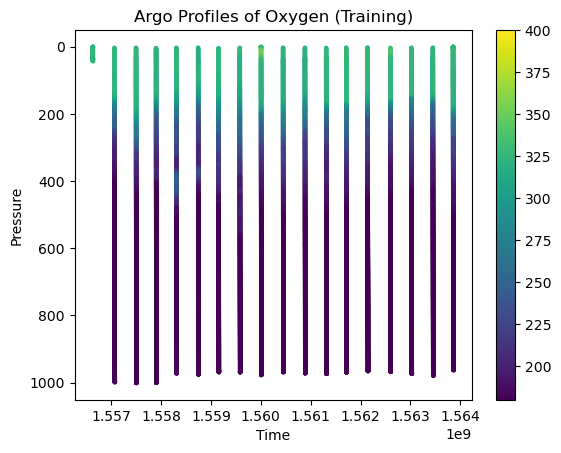

In [22]:
plt.scatter(time[train_i], DS_CTD.pressure.values[train_i], s = 5, c = ox_interp[train_i], vmin = 180, vmax = 400)
plt.colorbar()
plt.title("Argo Profiles of Oxygen (Training)")
plt.xlabel("Time")
plt.ylabel("Pressure")
# plt.xlim(1557000000, 1557200000)
plt.gca().invert_yaxis()
plt.show()

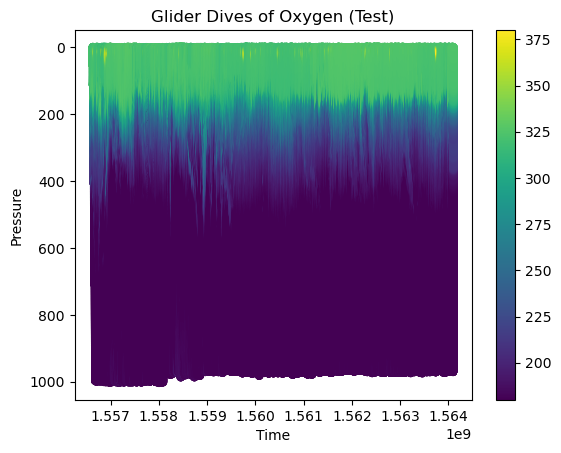

In [23]:
# Take a look at the ascent
plt.scatter(time[test_i], DS_CTD.pressure.values[test_i], c = ox_interp[test_i], vmin = 180, vmax = 380, edgecolors="none")
plt.colorbar()
plt.gca().invert_yaxis()
plt.title("Glider Dives of Oxygen (Test)")
plt.xlabel("Time")
plt.ylabel("Pressure")
plt.show()

In [24]:
X_train = np.transpose(np.array([DS_CTD.latitude.values[train_i], DS_CTD.longitude.values[train_i], DS_CTD.pressure.values[train_i], DS_CTD.temperature.values[train_i], DS_CTD.salinity.values[train_i]]))
Y_train = ox_interp[train_i]
X_test = np.transpose(np.array([DS_CTD.latitude.values[test_i], DS_CTD.longitude.values[test_i], DS_CTD.pressure.values[test_i], DS_CTD.temperature.values[test_i], DS_CTD.salinity.values[test_i]]))
Y_test = ox_interp[test_i]

In [25]:
rand.seed(1)
ntrees = 100
Mdl = RandomForestRegressor(ntrees, oob_score = True)
Mdl.fit(X_train, Y_train)

RandomForestRegressor(oob_score=True)

In [26]:
Y_pred = Mdl.predict(X_test)

In [27]:
AE_RF = Y_pred - Y_test
IQR_RF = iqr(AE_RF)

In [28]:
print('Median absolute error from RF prediction: ' + str(np.nanmedian(AE_RF)))
print('Interquartile Range from RF prediction: ' + str(IQR_RF))

Median absolute error from RF prediction: 0.4894074503997956
Interquartile Range from RF prediction: 2.112685005833569


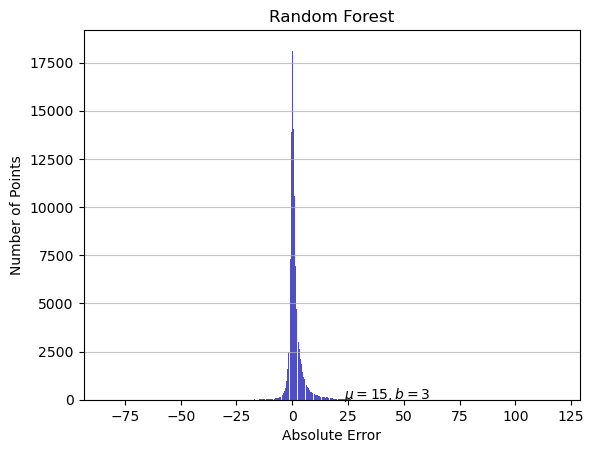

In [29]:
n, bins, patches = plt.hist(x=AE_RF, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Absolute Error")
plt.ylabel('Number of Points')
plt.title('Random Forest')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
plt.show()

In [30]:
Mdl.feature_importances_

array([4.63987786e-04, 3.88833455e-04, 3.85788581e-04, 8.43453598e-03,
       9.90326854e-01])

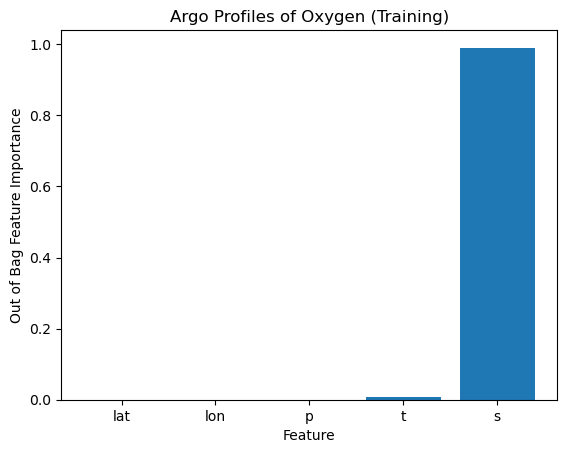

In [31]:
plt.bar(['lat','lon','p','t','s'], Mdl.feature_importances_)
plt.title("Argo Profiles of Oxygen (Training)")
plt.xlabel("Feature")
plt.ylabel("Out of Bag Feature Importance")
plt.show()

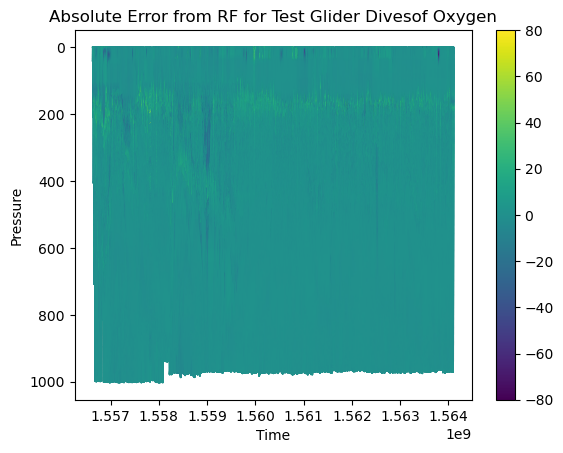

In [32]:
plt.scatter(time[test_i], DS_CTD.pressure.values[test_i], s = 0.1, c = AE_RF, vmin = -80, vmax = 80)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title("Absolute Error from RF for Test Glider Divesof Oxygen")
plt.xlabel("Time")
plt.ylabel("Pressure")
plt.show()

In [33]:
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)

LinearRegression()

In [34]:
Y_pred_MLR = regr.predict(X_test)

In [35]:
AE_MLR = Y_pred_MLR - Y_test
IQR_MLR = iqr(AE_MLR)

In [36]:
score=r2_score(Y_test,Y_pred_MLR)
score

-13.983522062561795

In [ ]:
n, bins, patches = plt.hist(x=AE_MLR, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Abosulte Error")
plt.ylabel('Number of Points')
plt.title('MLR')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
plt.xlim(-1000, 1000)
plt.show()

In [ ]:
plt.scatter(time[test_i], DS_CTD.pressure.values[test_i], s = 0.1, c = AE_MLR, vmin = -80, vmax = 80)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title("Absolute Error from MLR for Test Glider Divesof Oxygen")
plt.xlabel("Time")
plt.ylabel("Pressure")
plt.show()

In [ ]:
plt.scatter(time[test_i], DS_CTD.pressure.values[test_i], s = 0.1, c = Y_test, vmin = 180, vmax = 380)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title("Measured Oxygen Values")
plt.xlabel("Time")
plt.ylabel("Pressure")
plt.show()

In [ ]:
plt.scatter(time[test_i], DS_CTD.pressure.values[test_i], s = 0.1, c = Y_pred, vmin = 180, vmax = 380)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title("Predicted Oxygen Values (RF)")
plt.xlabel("Time")
plt.ylabel("Pressure")
plt.show()

In [ ]:
plt.scatter(time[test_i], DS_CTD.pressure.values[test_i], s = 0.1, c = Y_pred_MLR, vmin = 180, vmax = 380)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title("Predicted Values Oxygen (MLR)")
plt.xlabel("Time")
plt.ylabel("Pressure")
plt.show()

In [ ]:
Y_pred_MLR

In [ ]:
# Scipy GAM
# Other models?
# Add to training data, (shipboard data and float data)
# Predicting Nitrate and DIC, PCO2
# Have CTD data, backscatter (chlorophyll) data, and O2, from Glider, to predict
# Toggling algorithm options
# Satellite data?
# Tutorial at GO-BGC website, getting started with BGC data

In [ ]:
gam = LinearGAM().fit(X_train, Y_train)

In [ ]:
gam_predict = gam.predict(X_test)

In [ ]:
AE_GAM = gam_predict - Y_test
IQR_GAM = iqr(AE_GAM)

In [ ]:
gam.summary()

In [ ]:
n, bins, patches = plt.hist(x=AE_GAM, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Abosulte Error")
plt.ylabel('Number of Points')
plt.title('gam')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
plt.xlim(-1000, 1000)
plt.show()

In [ ]:
s(0) + l(1) + f(2) + te(3, 4

In [ ]:
plt.scatter(time[test_i], DS_CTD.pressure.values[test_i], s = 0.1, c = gam_predict, vmin = 180, vmax = 380)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title("Predicted Values Oxygen (GAM)")
plt.xlabel("Time")
plt.ylabel("Pressure")
plt.show()

In [ ]:
model = xgb.XGBRegressor()
model.fit(X_train, Y_train)

In [ ]:
XGB_pred = model.predict(X_test)

In [ ]:
AE_XGB = XGB_pred - Y_test
IQR_XGB = iqr(AE_XGB)

In [ ]:
n, bins, patches = plt.hist(x=AE_XGB, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel("Abosulte Error")
plt.ylabel('Number of Points')
plt.title('gam')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
plt.xlim(-1000, 1000)
plt.show()

In [ ]:
plt.scatter(time[test_i], DS_CTD.pressure.values[test_i], s = 0.1, c = XGB_pred, vmin = 180, vmax = 380)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title("Predicted Values Oxygen (XGB)")
plt.xlabel("Time")
plt.ylabel("Pressure")
plt.show()

In [ ]:
error_dict = {}
error_dict["Model"] = ["RF", "MLR", "GAM", "XGBoost"]
error_dict["Absolute Error"] = [np.nanmedian(AE_RF), np.nanmedian(AE_MLR), np.nanmedian(AE_GAM), "N/A"]
error_dict["IQR"] = [IQR_RF, IQR_MLR, IQR_GAM, "N/A"]

In [ ]:
error_DF = pd.DataFrame.from_dict(error_dict)
error_DF

In [ ]:
combinations = list(itertools.product("lsf", repeat=5))
result_dict = {}

In [ ]:
j = 0
for i in combinations:
    GAM_String = "LinearGAM(" + i[0] + "(0) +" + i[1] + "(1) +" + i[2] + "(2) +" + i[3] + "(3) +" + i[4] + "(4)" + ").fit(X_train, Y_train)"
    print(GAM_String)
    gam = eval(GAM_String)
    gam_predict = gam.predict(X_test)
    AE_gam = gam_predict - Y_test
    IQR_gam = iqr(AE_gam)
    result_dict[i[0]+i[1]+i[2]+i[3]+i[4]] = [np.nanmedian(AE_gam), IQR_gam]
    print(j)
    if j == 3:
        break